In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

save_dir = '/content/drive/MyDrive/saved_models'
os.makedirs(save_dir, exist_ok=True)



In [ ]:
save_dir = '/content/drive/MyDrive/saved_models'

if os.path.exists(save_dir):
    print(f"Directory exists: {save_dir}")
    print("Contents:", os.listdir(save_dir))
else:
    print("Directory was not created.")


Directory exists: /content/drive/MyDrive/saved_models
Contents: ['mnist_e5.h5', 'mnist_e10.h5', 'mnist_e15.h5', 'fashion_mnist_e5.h5', 'fashion_mnist_e10.h5', 'fashion_mnist_e15.h5', 'cifar_10_e5.h5', 'cifar_10_e10.h5', 'cifar_10_e15.h5', 'iris_4conv_e5.h5', 'iris_4conv_e10.h5', 'iris_4conv_e15.h5', 'iris_cnn_e5.h5', 'iris_cnn_e10.h5', 'iris_cnn_e15.h5']


# Load Dataset & Preprocessing

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "training.1600000.processed.noemoticon.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "kazanova/sentiment140",
    file_path,
    pandas_kwargs={"encoding": "ISO-8859-1"}
)

df.columns = [
    "target",
    "id",
    "date",
    "flag",
    "user",
    "text"
]

print(df.head())


<ipython-input-4-899c176d76d2>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


   target          id                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   


In [ ]:
import re

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_tweet)
df['target'] = df['target'].replace(4, 1)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=50)

In [ ]:
for i in range(2):
    print("Tweet:", df['clean_text'][i])
    print("Tokens:", sequences[i])
    print("Padded:", padded_sequences[i])
    print("-" * 50)


Tweet: is upset that he cant update his facebook by texting it and might cry as a result school today also blah
Tokens: [9, 772, 19, 107, 47, 538, 178, 542, 120, 2000, 10, 7, 282, 522, 78, 5, 2274, 145, 43, 259, 1186]
Padded: [   9  772   19  107   47  538  178  542  120 2000   10    7  282  522
   78    5 2274  145   43  259 1186    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
--------------------------------------------------
Tweet: i dived many times for the ball managed to save the rest go out of bounds
Tokens: [2, 1, 307, 346, 11, 4, 1328, 1616, 3, 893, 4, 466, 39, 35, 13, 1]
Padded: [   2    1  307  346   11    4 1328 1616    3  893    4  466   39   35
   13    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
-------------------------------------------------

# Train Test Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(padded_sequences)
y = np.array(df['target'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size :", X_train.shape)
print("Testing size  :", X_test.shape)


Training size : (1279999, 50)
Testing size  : (320000, 50)


# ML


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("Logistic Regression")
print(f"Training Accuracy : {train_acc * 100:.2f}%")
print(f"Testing Accuracy  : {test_acc * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

joblib.dump(clf, '/content/drive/MyDrive/ColabNotebooks/saved_models/logistic_sentiment_model.pkl')
joblib.dump(vectorizer, '/content/drive/MyDrive/ColabNotebooks/saved_models/tfidf_vectorizer.pkl')
print("Model and vectorizer successfully saved.")


Logistic Regression
Training Accuracy : 79.85%
Testing Accuracy  : 79.52%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    160000
           1       0.79      0.81      0.80    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Model and vectorizer successfully saved.


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svc_model = LinearSVC()
svc_model.fit(X_train, y_train)

y_train_pred = svc_model.predict(X_train)
y_test_pred = svc_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred) * 100
test_acc = accuracy_score(y_test, y_test_pred) * 100

print("Linear SVC")
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy : {test_acc:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

joblib.dump(svc_model, '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_svc_model.pkl')
print("\nModel saved successfully to: '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_svc_model.pkl'")


Linear SVC
Training Accuracy: 79.88%
Testing Accuracy : 79.47%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79    160000
           1       0.79      0.81      0.80    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000


Model saved successfully to: '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_svc_model.pkl'


In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)

y_train_pred = bnb_model.predict(X_train)
y_test_pred = bnb_model.predict(X_test)

print("Bernoulli Naive Bayes")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print(f"Testing Accuracy : {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
joblib.dump(bnb_model, '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_bnb_model.pkl')
print("\nModel saved successfully to: '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_bnb_model.pkl'")


Bernoulli Naive Bayes
Training Accuracy: 77.73%
Testing Accuracy : 77.46%
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77    160000
           1       0.77      0.79      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000


Model saved successfully to: '/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_bnb_model.pkl'


# CNN


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D,
                                   GlobalMaxPooling1D, Dense, Dropout,
                                   BatchNormalization, SpatialDropout1D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

VOCAB_SIZE = 20000
EMBEDDING_DIM = 256
MAX_LEN = 50
EPOCHS = 15
BATCH_SIZE = 256
DROPOUT_RATE = 0.5
L2_REG = 0.0001

model = Sequential()

model.add(Embedding(input_dim=VOCAB_SIZE,
                   output_dim=EMBEDDING_DIM,
                   input_length=MAX_LEN,
                   embeddings_regularizer=l2(L2_REG)))

model.add(SpatialDropout1D(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                kernel_regularizer=l2(L2_REG)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(DROPOUT_RATE))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
                kernel_regularizer=l2(L2_REG)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(DROPOUT_RATE))

model.add(Conv1D(filters=512, kernel_size=5, activation='relu', padding='same',
                kernel_regularizer=l2(L2_REG)))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dropout(DROPOUT_RATE))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2_REG)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2_REG)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.save("sentiment_cnn_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 98s 17ms/step - accuracy: 0.7253 - loss: 0.7217 - val_accuracy: 0.8088 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 0.8019 - loss: 0.5338 - val_accuracy: 0.8093 - val_loss: 0.5191 - learning_rate: 0.0010
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8022 - loss: 0.5346 - val_accuracy: 0.8124 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - accuracy: 0.8045 - loss: 0.5316 - val_accuracy: 0.8093 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 69s 14ms/step - accuracy: 0.8046 - loss: 0.5298 - val_accuracy: 0.8125 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.8144 - loss: 0.4818 - val_accuracy: 0.8252 - val_loss: 0.4355 - learning_rate: 2.0000e-04
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - a

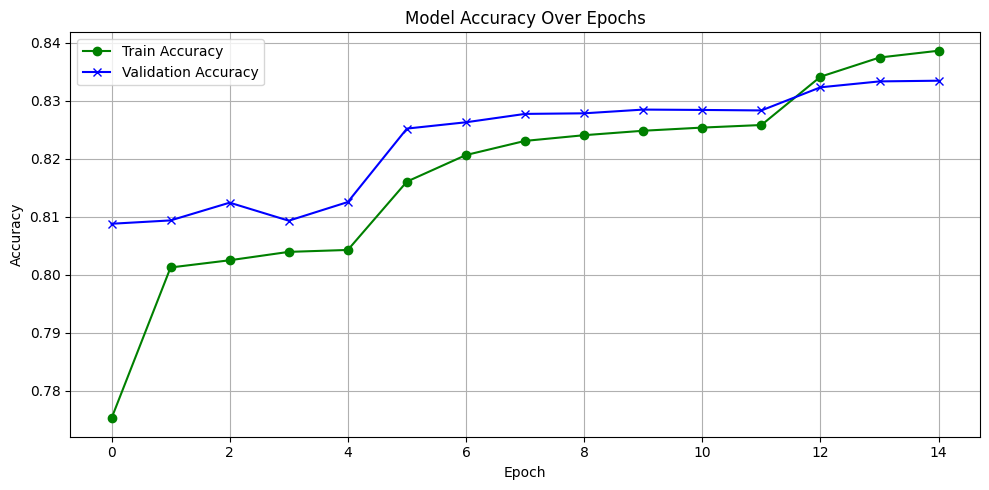

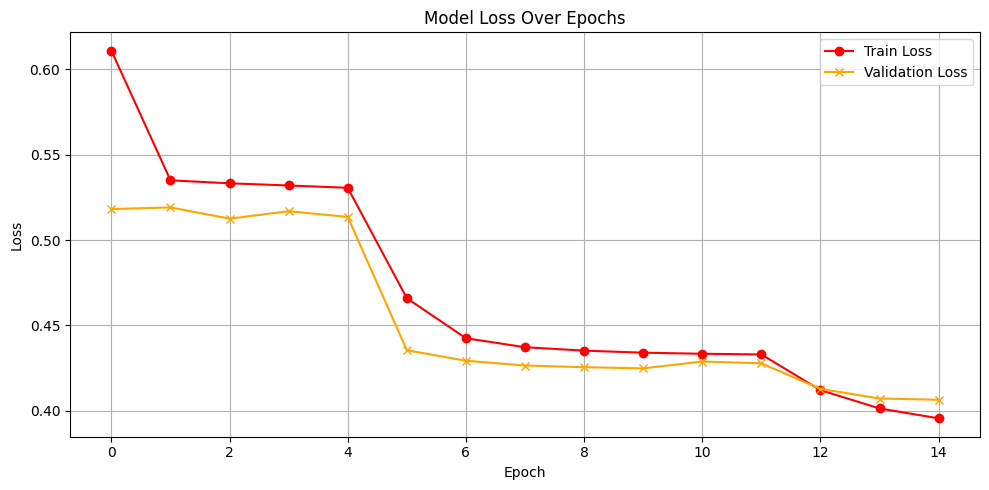

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x', color='blue')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# RNN


In [ ]:
import os
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

X = padded_sequences
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.build(input_shape=(None, X_train.shape[1]))
print("\n Model Summary:\n")
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

trained_epochs = len(history.history['loss'])

train_acc = history.history['accuracy'][trained_epochs - 1]
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"\n Training stopped after {trained_epochs} epochs")
print(f" Final Training Accuracy: {train_acc * 100:.2f}%")
print(f" Test Accuracy: {test_acc * 100:.2f}%")

save_path = "/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_rnn_model.keras"
history_path = "/content/drive/MyDrive/ColabNotebooks/saved_models/sentiment_rnn_history.pkl"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)

trimmed_history = {k: v[:trained_epochs] for k, v in history.history.items()}
with open(history_path, 'wb') as f:
    pickle.dump(trimmed_history, f)

print(f"\n Model saved to: {save_path}")
print(f"Training history saved to: {history_path}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



 Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,096,705 (11.81 MB)

 Trainable params: 3,095,681 (11.81 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 500s 27ms/step - accuracy: 0.7651 - loss: 0.4922 - val_accuracy: 0.8149 - val_loss: 0.4017 - learning_rate: 0.0010
Epoch 2/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 489s 27ms/step - accuracy: 0.8237 - loss: 0.3976 - val_accuracy: 0.8217 - val_loss: 0.3928 - learning_rate: 0.0010
Epoch 3/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 476s 26ms/step - accuracy: 0.8340 - loss: 0.3777 - val_accuracy: 0.8269 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 4/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 514s 27ms/step - accuracy: 0.8403 - loss: 0.3656 - val_accuracy: 0.8278 - val_loss: 0.3820 - learning_rate: 0.0010
Epoch 5/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 511s 28ms/step - accuracy: 0.8459 - loss: 0.3550 - val_accuracy: 0.8273 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 6/8
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8502 - loss: 0.3464
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 504s 28ms/s

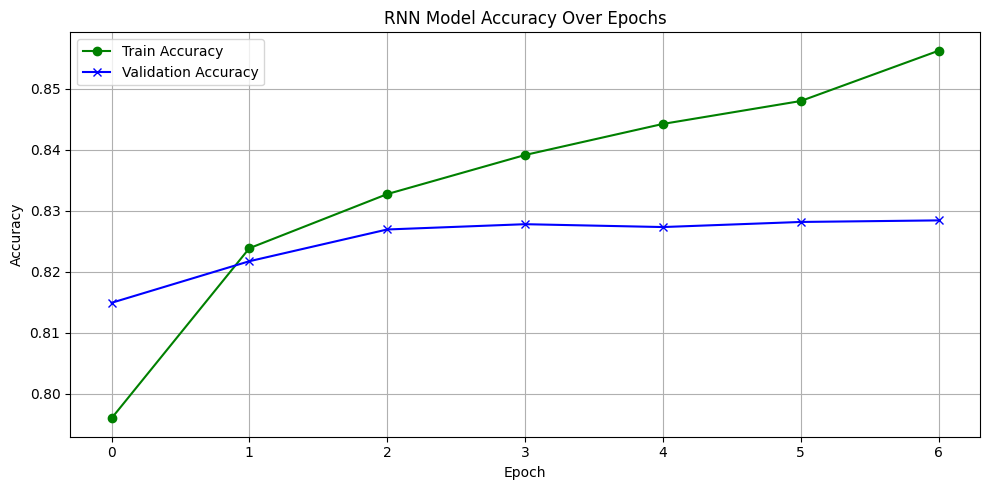

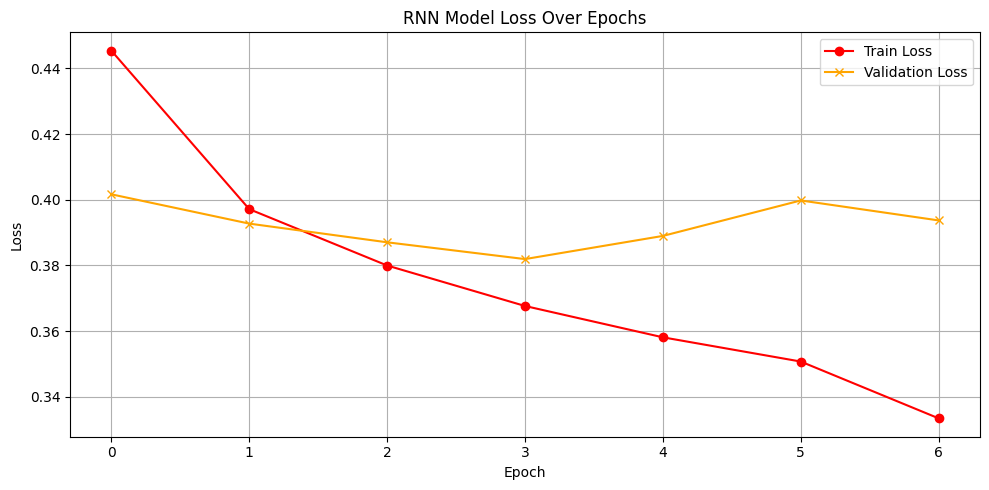

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x', color='blue')
plt.title('RNN Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x', color='orange')
plt.title('RNN Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle

history_path = "/content/drive/MyDrive/ColabNotebooks/saved_models/rnn_training_history.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"Training history saved to: {history_path}")


Training history saved to: /content/drive/MyDrive/ColabNotebooks/saved_models/rnn_training_history.pkl


# CNN + RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional,
                                    Dense, Dropout, GlobalMaxPooling1D, SpatialDropout1D)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
MAX_LEN = 50
EPOCHS = 10
BATCH_SIZE = 64
DROPOUT_RATE = 0.5

model = Sequential()

model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(DROPOUT_RATE))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(DROPOUT_RATE))
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 25, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,334,721 (8.91 MB)

 Trainable params: 2,334,721 (8.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 246s 12ms/step - accuracy: 0.7865 - loss: 0.4536 - val_accuracy: 0.8192 - val_loss: 0.4255
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 245s 12ms/step - accuracy: 0.8250 - loss: 0.3914 - val_accuracy: 0.8255 - val_loss: 0.4151
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 238s 12ms/step - accuracy: 0.8317 - loss: 0.3791 - val_accuracy: 0.8261 - val_loss: 0.4202
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 260s 12ms/step - accuracy: 0.8354 - loss: 0.3719 - val_accuracy: 0.8262 - val_loss: 0.4150
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 271s 12ms/step - accuracy: 0.8392 - loss: 0.3648 - val_accuracy: 0.8273 - val_loss: 0.4212
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 258s 12ms/step - accuracy: 0.8403 - loss: 0.3630 - val_accuracy: 0.8266 - val_loss: 0.4143
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 264s 12ms/step - accuracy: 0.8424 - loss: 0.3597 - val_accuracy: 0.8272 - val_loss: 0.4203
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 263s 12ms/s

<ipython-input-14-4ee15cdc24d6>:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-4ee15cdc24d6>:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


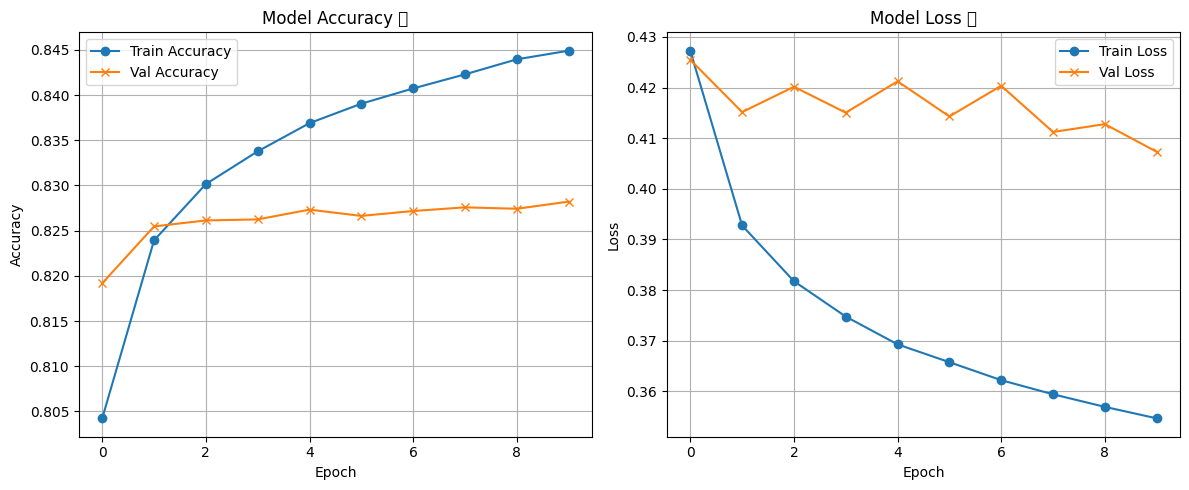

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy 📈')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss 📉')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Autoencoder


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

X = np.random.rand(60000, 40, 1).astype('float32')
y = X.copy()

split = int(0.9 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

latent_dim = 128

inputs = Input(shape=(40, 1))
x = LSTM(256, activation='tanh', return_sequences=True)(inputs)
x = LSTM(latent_dim, activation='tanh', return_sequences=False)(x)

x = RepeatVector(40)(x)
x = LSTM(128, activation='tanh', return_sequences=True)(x)
x = LSTM(64, activation='tanh', return_sequences=True)(x)
outputs = TimeDistributed(Dense(1))(x)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.summary()

history = autoencoder.fit(
    X_train, y_train,
    epochs=10,
    batch_size=10,
    validation_data=(X_val, y_val),
    verbose=1
)

def compute_accuracy(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    max_val = np.max(y_true)
    acc = (1 - rmse / max_val) * 100
    return np.clip(acc, 0, 100)

train_pred = autoencoder.predict(X_train, verbose=0)
val_pred = autoencoder.predict(X_val, verbose=0)

train_acc = compute_accuracy(y_train, train_pred)
val_acc = compute_accuracy(y_val, val_pred)

print(f"\nTraining Accuracy: {train_acc:.2f}%")
print(f"Testing Accuracy : {val_acc:.2f}%")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 40, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 40, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 40, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,369 (2.45 MB)

 Trainable params: 642,369 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - loss: 0.0772 - val_loss: 0.0554
Epoch 2/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 0.0506 - val_loss: 0.0360
Epoch 3/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 0.0316 - val_loss: 0.0217
Epoch 4/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 0.0181 - val_loss: 0.0100
Epoch 5/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 6/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - loss: 0.0012 - val_loss: 8.1749e-04
Epoch 8/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 8.9200e-04 - val_loss: 4.6699e-04
Epoch 9/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - loss: 7.8410e-04 - val_loss: 0.0084
Epoch 10/10
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0010 - val_loss: 3.6907e-04

Training Accuracy: 98.09%
Testing Accuracy : 98.08%


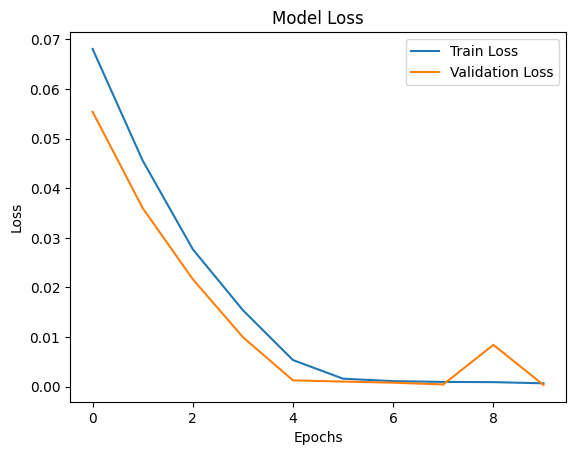

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
